In [1]:
!pip install wandb -q

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from numpy import asarray
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Currently logged in as: sachinvashistha (iit_dl). Use `wandb login --relogin` to force relogin


True

In [4]:
masked_train_path = '/kaggle/input/photo-reconstruction/Dataset/Training_Data/'
unmasked_train_path = '/kaggle/input/photo-reconstruction/Dataset/Training_Data/'
masked_test_path = '/kaggle/input/photo-reconstruction/Dataset/Testing_Data/'

In [5]:
def show_images(img):
    fig = plt.figure(figsize=(16., 8.))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.3,)
    for ax, image in zip(grid, img):
        ax.imshow(image)
    plt.show()

In [6]:
def load_data(path, animal = '', mask = ''):
    Folder = path + animal + mask
    list_images = []
    for File_name in os.listdir(Folder):
        if File_name.endswith('jpeg') or File_name.endswith('jpg') or File_name.endswith('png'):
            img = Image.open(os.path.join(Folder,File_name))
            if img is not None:
                list_images.append(asarray(img))
    return list_images

In [7]:
masked_Cat = load_data(masked_train_path, 'Cat/', 'Masked_Train/')
masked_Dog = load_data(masked_train_path, 'Dog/', 'Masked_Train/')
masked_Elephant = load_data(masked_train_path, 'Elephant/', 'Masked_Train/')
masked_Tiger = load_data(masked_train_path, 'Tiger/', 'Masked_Train/')

Unmasked_Cat = load_data(unmasked_train_path, 'Cat/', 'Unmasked_Train/')
Unmasked_Dog = load_data(unmasked_train_path, 'Dog/', 'Unmasked_Train/')
Unmasked_Elephant = load_data(unmasked_train_path, 'Elephant/', 'Unmasked_Train/')
Unmasked_Tiger = load_data(unmasked_train_path, 'Tiger/', 'Unmasked_Train/')

#test_data = load_data(masked_test_path)

In [8]:
masked_Total = masked_Cat + masked_Dog + masked_Elephant + masked_Tiger
x_train_masked = asarray(masked_Total)

In [9]:
print(x_train_masked.shape)

(7000, 256, 256, 3)


In [10]:
Unmasked_Total = Unmasked_Cat + Unmasked_Dog + Unmasked_Elephant + Unmasked_Tiger
y_train_Unmasked = asarray(Unmasked_Total)

In [11]:
print(y_train_Unmasked.shape)

(7000, 256, 256, 3)


In [ ]:
#x_test_masked = asarray(test_data)

In [ ]:
#print(x_test_masked.shape)

In [12]:
class prepare_data(keras.utils.Sequence):
    
    def __init__(self, X, Y, Dimension = (256, 256), Batch_Size = 32, Channels = 3, shuffle = True):
        self.X = X 
        self.Y = Y
        self.Dimension = Dimension
        self.Batch_Size = Batch_Size 
        self.Channels = Channels
        self.shuffle = shuffle
        self.after_Epoch()
        
    def __len__(self):
        return int(np.floor(len(self.X) / self.Batch_Size))
    
    def __getitem__(self, Index):
        Indexes = self.Indexes[Index * self.Batch_Size:(Index + 1) * self.Batch_Size]
        return self.__fetch_data(Indexes)
    
    def after_Epoch(self):
        self.Indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.Indexes)
            
    def __fetch_data(self, ind):
        X_batch = np.empty((self.Batch_Size, self.Dimension[0], self.Dimension[1], self.Channels))
        Y_batch = np.empty((self.Batch_Size, self.Dimension[0], self.Dimension[1], self.Channels))
        
        for j, index in enumerate(ind):
            
            X_batch[j,] = self.X[index] / 255
            Y_batch[j] = self.Y[index] / 255
            
        return X_batch, Y_batch
    

In [13]:
prep_train = prepare_data(x_train_masked, y_train_Unmasked)

In [14]:
print(type(prep_train))
print(len(prep_train))
print("*****************************")
print(type(prep_train[0]))
print(len(prep_train[0]))
print("*****************************")
print(type(prep_train[0][0]))
print(prep_train[0][0].shape)
print(prep_train[0][1].shape)

<class '__main__.prepare_data'>
218
*****************************
<class 'tuple'>
2
*****************************
<class 'numpy.ndarray'>
(32, 256, 256, 3)
(32, 256, 256, 3)


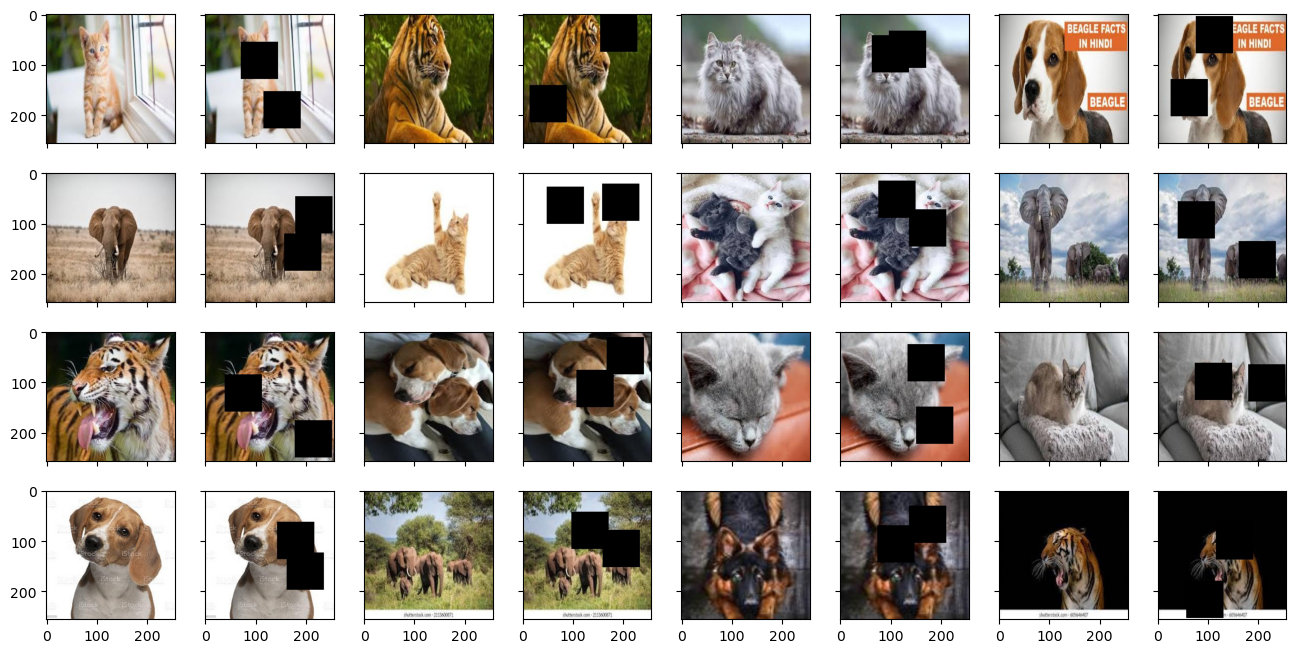

In [15]:
show_Index = 0

show_masks, show_original = prep_train[show_Index]
show_images = [None]*(len(show_masks)+len(show_original))
show_images[::2] = show_original
show_images[1::2] = show_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.3, )

for ax, image in zip(grid, show_images):
    ax.imshow(image)

plt.show()

***> AutoEncoder-Decoder Model***

In [16]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [17]:
class inpaintingModel:
    def prepare_model(self, input_size=(256,256,3)):
        inputs = keras.layers.Input(input_size)

        conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
        conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 

        conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

        outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

        return keras.models.Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = keras.layers.MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = keras.layers.concatenate([up, shared_layer], axis=3)

        return conv, up

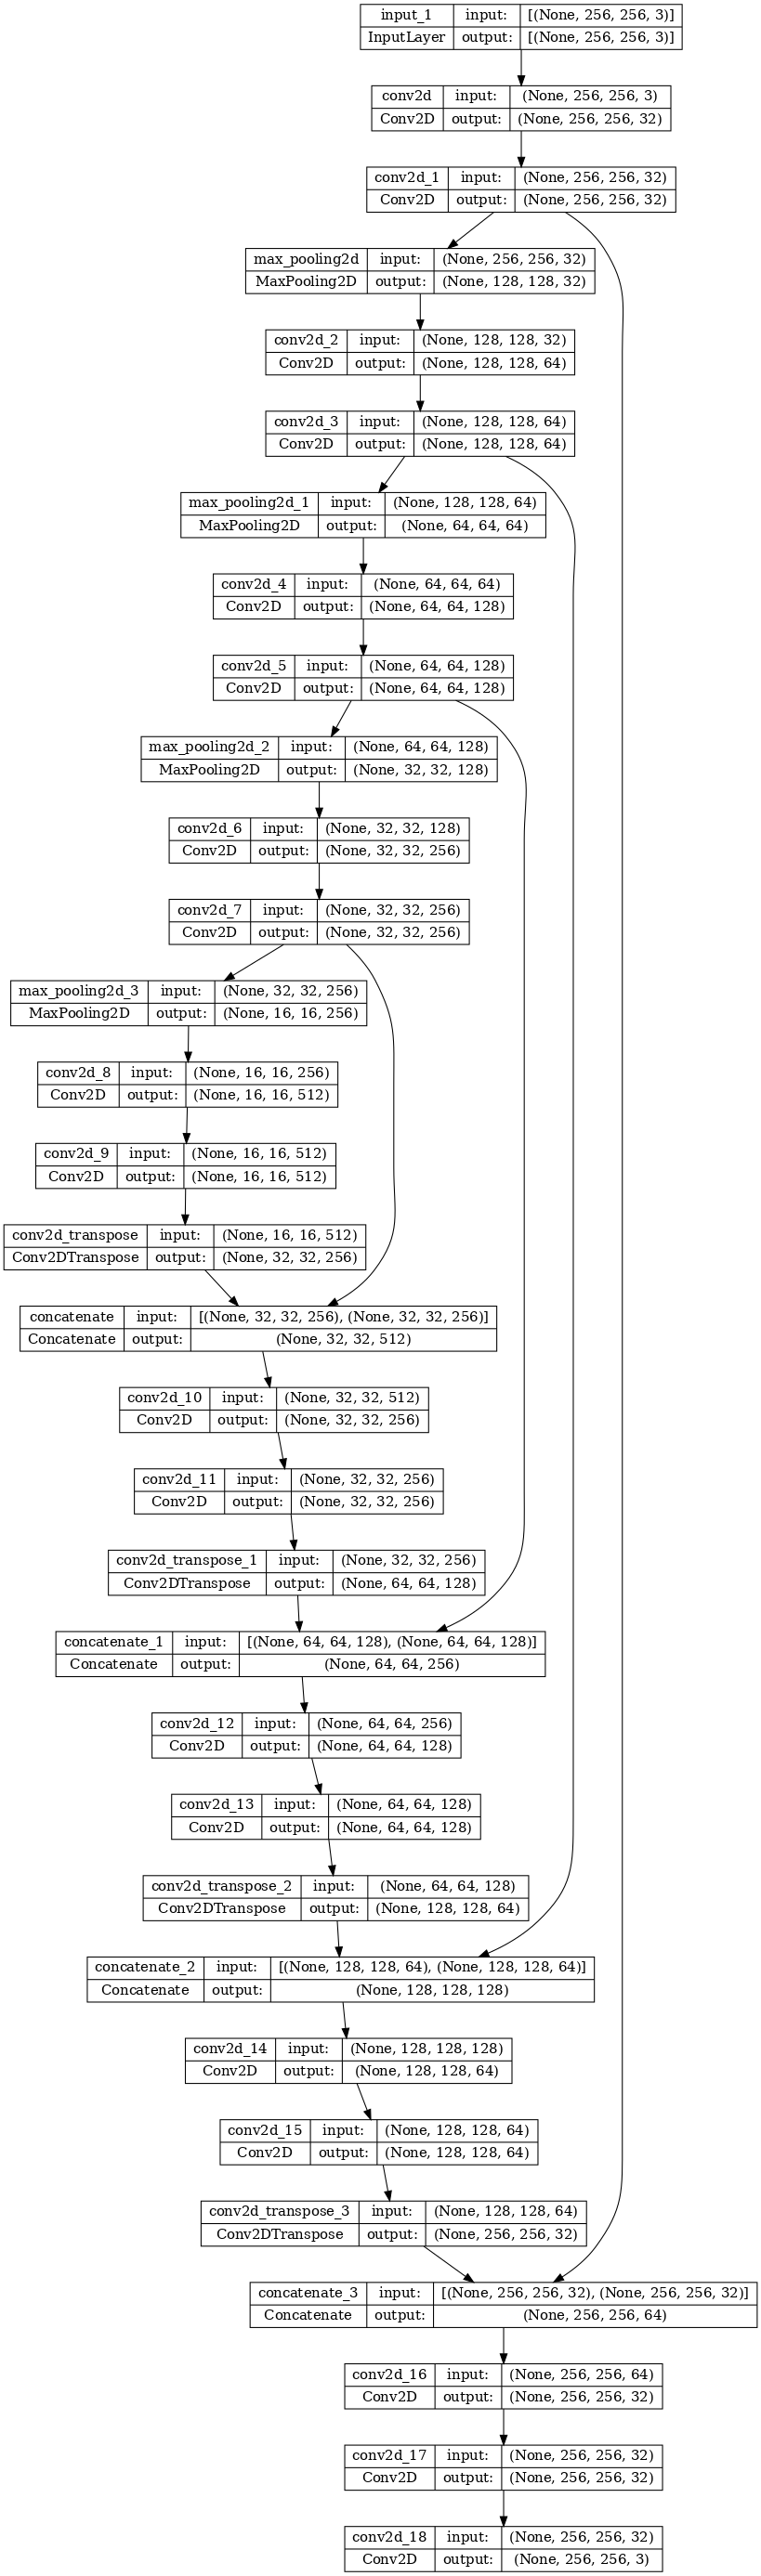

In [18]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

In [19]:
wandb.init(entity='sachinvashistha', project="Photo_reconstruction")

wandb: Currently logged in as: sachinvashistha. Use `wandb login --relogin` to force relogin


In [20]:
_ = model.fit(prep_train,
          epochs = 20, 
          steps_per_epoch = len(prep_train),
          use_multiprocessing = True,
          callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
218/218 [==============================] - 179s 728ms/step - loss: 0.0841 - dice_coef: 0.6236
Epoch 2/20
218/218 [==============================] - 176s 800ms/step - loss: 0.0396 - dice_coef: 0.6463
Epoch 3/20
218/218 [==============================] - 173s 793ms/step - loss: 0.0351 - dice_coef: 0.6480
Epoch 4/20
218/218 [==============================] - 172s 784ms/step - loss: 0.0307 - dice_coef: 0.6493
Epoch 6/20
218/218 [==============================] - 172s 784ms/step - loss: 0.0303 - dice_coef: 0.6496
Epoch 7/20
218/218 [==============================] - 171s 783ms/step - loss: 0.0273 - dice_coef: 0.6499
Epoch 8/20
218/218 [==============================] - 171s 777ms/step - loss: 0.0270 - dice_coef: 0.6502
Epoch 9/20
218/218 [==============================] - 182s 827ms/step - loss: 0.0264 - dice_coef: 0.6502
Epoch 10/20
218/218 [==============================] - 166s 758ms/step - loss: 0.0272 - dice_coef: 0.6505
Epoch 11/20
218/218 [==============================] -

In [36]:
!tar -zcvf Output_file.tar.gz /kaggle/working

tar: Removing leading `/' from member names
/kaggle/working/
/kaggle/working/wandb/
/kaggle/working/wandb/run-20230405_133552-pgsntr11/
/kaggle/working/wandb/run-20230405_133552-pgsntr11/run-pgsntr11.wandb
/kaggle/working/wandb/run-20230405_133552-pgsntr11/files/
/kaggle/working/wandb/run-20230405_133552-pgsntr11/files/config.yaml
/kaggle/working/wandb/run-20230405_133552-pgsntr11/files/wandb-metadata.json
/kaggle/working/wandb/run-20230405_133552-pgsntr11/files/requirements.txt
/kaggle/working/wandb/run-20230405_133552-pgsntr11/files/output.log
/kaggle/working/wandb/run-20230405_133552-pgsntr11/files/Image_Reconstruct_model.h5
/kaggle/working/wandb/run-20230405_133552-pgsntr11/files/conda-environment.yaml
/kaggle/working/wandb/run-20230405_133552-pgsntr11/files/wandb-summary.json
/kaggle/working/wandb/run-20230405_133552-pgsntr11/files/media/
/kaggle/working/wandb/run-20230405_133552-pgsntr11/files/media/graph/
/kaggle/working/wandb/run-20230405_133552-pgsntr11/files/media/graph/graph

In [21]:
model.save(os.path.join(wandb.run.dir, "Image_Reconstruct_model.h5"))

In [22]:
wandb.save('Image_Reconstruct_model.h5')

['/kaggle/working/wandb/run-20230405_133552-pgsntr11/files/Image_Reconstruct_model.h5']

1/1 [==============================] - 0s 23ms/step


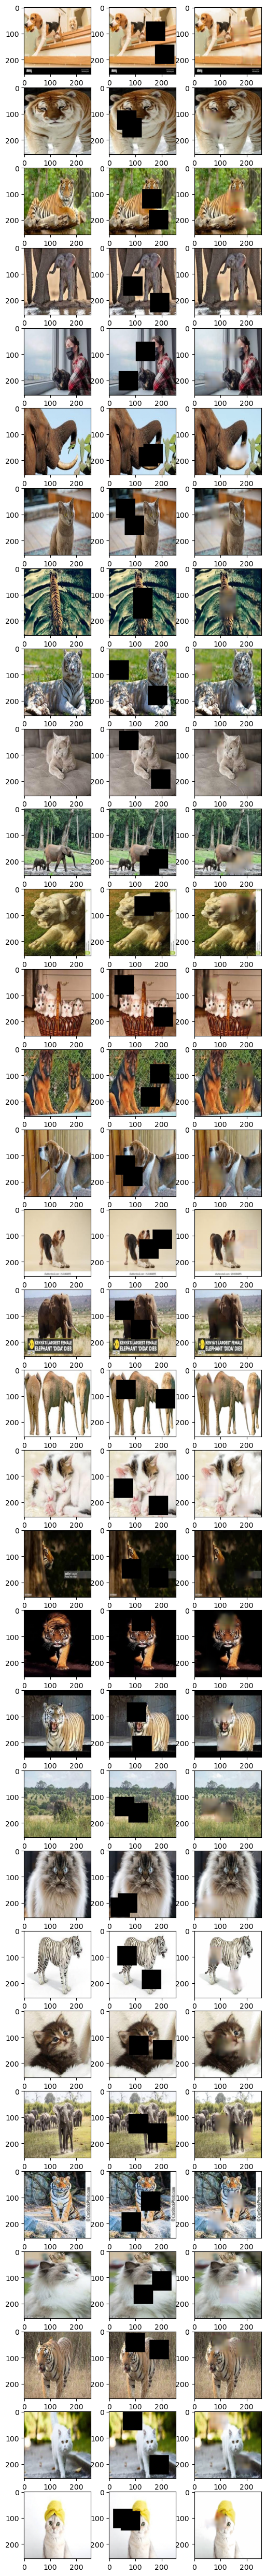

In [23]:
rows = 32
sample_idx = 54
sample_images, sample_labels = prep_train[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

for i in range(32):
    impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
    axs[i][0].imshow(sample_labels[i])
    axs[i][1].imshow(sample_images[i])
    axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()

In [24]:
# collect the test images
def load_test_data(path):
    Folder = path
    list_images = []
    list_image_names = []
    for File_name in os.listdir(Folder):
        if File_name.endswith('jpeg') or File_name.endswith('jpg') or File_name.endswith('png'):
            
            img = Image.open(os.path.join(Folder,File_name))
            if img is not None:
                list_images.append(asarray(img))
                list_image_names.append(File_name)
    return list_images, list_image_names


In [25]:
test_images, test_image_names = load_test_data(masked_test_path)

In [26]:
print(len(test_images))
print(len(test_image_names))

200
200


In [ ]:
#print(test_image_names)

In [27]:
test_image_array = asarray(test_images)
print(test_image_array.shape)
print(len(test_image_array))

(200, 256, 256, 3)
200


In [ ]:
temp_img = test_image_array[0]
print(temp_img.shape)
print(temp_img.reshape((1,) + temp_img.shape).shape)
print(temp_img.shape)

In [28]:
import math

batchSize = 32
predicted_matrix = []
for a in range(0, math.floor(len(test_image_array) / batchSize) + 1):
    for b in range(0, batchSize):
        if len(test_image_array) - (b + 1 + (a * batchSize)) >= 0:
            predicted_matrix.append(model.predict(test_image_array[b + (a * batchSize)].reshape((1,) + test_image_array[b + (a * batchSize)].shape)))
            #print(test_image_names[b + (a * batchSize)])
            #print(b + (a * batchSize))

print(len(predicted_matrix))

1/1 [==============================] - 0s 25ms/step
200


In [31]:
df = pd.read_csv(masked_test_path + "masked_info.csv")
print(len(df))

200


In [32]:
def submission(file_name, matrix, r, c, no):
    
    temp_list = []
    for row in range(0, 75):
        for col in range(0, 75):
            channel = 0
            for ch in range(3):
                first_val = file_name + "_" + "box" + str(no) + "_" + str(row + r) + "_" + str(col + c) + "_" + str(channel)
                channel += 1
                second_val = matrix[:, :, ch][(row + r), (col + c)]
                temp_list.append([first_val, second_val])
                
    #print(temp_list)
    return temp_list
    

In [33]:
print(predicted_matrix[0].shape)
print(predicted_matrix[0][0, :].shape)
for i in range(3):
    print(predicted_matrix[0][0, :][:, :, i].shape)
    print("******************************")

(1, 256, 256, 3)
(256, 256, 3)
(256, 256)
******************************
(256, 256)
******************************
(256, 256)
******************************


In [34]:
final_list = []
for i in range(len(df)):
    index = test_image_names.index(df['filename'].iloc[i])
    #print(df['filename'].iloc[i])
    #print(index)
    
    box1_r = df['box1_row'].iloc[i]
    box1_c = df['box1_col'].iloc[i]
    box2_r = df['box2_row'].iloc[i]
    box2_c = df['box2_col'].iloc[i]
    
    list_b1 = submission(df['filename'].iloc[i], predicted_matrix[index][0, :], box1_r, box1_c, 1)
    list_b2 = submission(df['filename'].iloc[i], predicted_matrix[index][0, :], box2_r, box2_c, 2)
    final_list += (list_b1 + list_b2)
    
df_final = pd.DataFrame(final_list, columns =['filename_box_pixel', 'Value'], dtype = float)
#df_final = df_final.reset_index(drop=True, inplace = True)
df_final.to_csv("photo_reconstruct_submission.csv", index = False)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
print(df_final["Value"].between(0,1).all())

True


In [ ]:
print(df_final[])

In [ ]:
os.remove("/kaggle/working/photo_reconstruct_submission.csv")